<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/DatamatrixError.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opencv-python numpy


--percentile 96 (más sensible) o --percentile 98 (más estricto)

--min-band 2 --max-band 40 si la raya puede ser más gruesa/delgada

--alpha 0.5..0.8 para equilibrar brillo vs. uniformidad.

Detected 2 horizontal white band(s): [(95, 96), (282, 288)]
Annotated image saved to: /content/sampleImage_annot.png


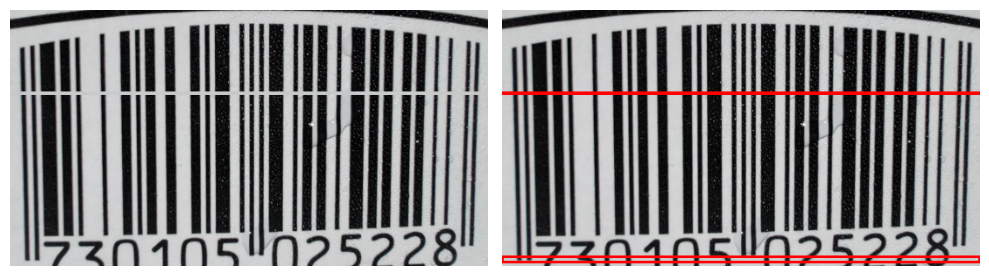

In [20]:
# single_image_white_gap.py
# Detecta línas blancas en código de barras

import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ------------------------------
# Núcleo: detección por perfil 1D
# ------------------------------
def detect_horizontal_white_gaps(
    gray: np.ndarray,
    alpha: float = 0.6,          # pondera cuánto penaliza la variación horizontal (std)
    min_band_px: int = 2,        # grosor mínimo aceptado (px)
    max_band_px: int = 30,       # grosor máximo aceptado (px)
    percentile_thr: float = 97.0 # umbral automático por percentil del score
):
    """
    Retorna:
      - bands: lista de tuplas (y0, y1) inclusive con las bandas detectadas
      - score_smooth: score por fila suavizado (vector 1D)
      - thr: umbral usado
    """
    # Normaliza a [0,1]
    g = gray.astype(np.float32)
    if g.max() > 1.0:
        g /= 255.0

    # Suaviza para reducir ruido
    g_blur = cv2.GaussianBlur(g, (5, 5), 0)

    # Promedio y desviación por fila (a lo largo de columnas)
    row_mean = g_blur.mean(axis=1)
    row_std  = g_blur.std(axis=1)

    # Filas brillantes y uniformes => score alto
    score = row_mean - alpha * row_std

    # Suaviza perfil 1D para evitar picos espurios
    k = 9
    kernel = np.ones(k, dtype=np.float32) / k
    score_smooth = np.convolve(score, kernel, mode="same")

    # Umbral por percentil
    thr = np.percentile(score_smooth, percentile_thr)
    mask = score_smooth >= thr

    # Agrupa filas contiguas positivas en bandas
    bands = []
    in_band = False
    start = 0
    for i, val in enumerate(mask):
        if val and not in_band:
            in_band = True
            start = i
        elif not val and in_band:
            in_band = False
            end = i - 1
            if min_band_px <= (end - start + 1) <= max_band_px:
                bands.append((start, end))
    if in_band:
        end = len(mask) - 1
        if min_band_px <= (end - start + 1) <= max_band_px:
            bands.append((start, end))

    return bands, score_smooth, thr


def main():
    # Carga única de "sampleImage.png" desde el cwd
    img_path = Path("/content/sample_data/conaprole4.png")
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"No se pudo leer {img_path.resolve()}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecta bandas
    bands, _, _ = detect_horizontal_white_gaps(
        gray,
        alpha=0.6,           # ajustar según dataset
        min_band_px=2,
        max_band_px=30,
        percentile_thr=97.0, # 96 => más sensible, 98 => más estricto
    )

    # Anota la imagen (opcional) y guarda
    annot = img.copy()
    for (y0, y1) in bands:
        cv2.rectangle(annot, (0, y0), (annot.shape[1] - 1, y1), (255, 0, 0), 2)

    out_path = Path("sampleImage_annot.png")
    cv2.imwrite(str(out_path), annot)

    # Reporte mínimo por consola
    if bands:
        print(f"Detected {len(bands)} horizontal white band(s): {bands}")
    else:
        print("No horizontal white bands detected.")
    print(f"Annotated image saved to: {out_path.resolve()}")

    # Mostrar imagenes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img)
    axs[0].axis('off')

    axs[1].imshow(annot)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Bands: []
Annotated saved to: /content/sampleImage_annot.png


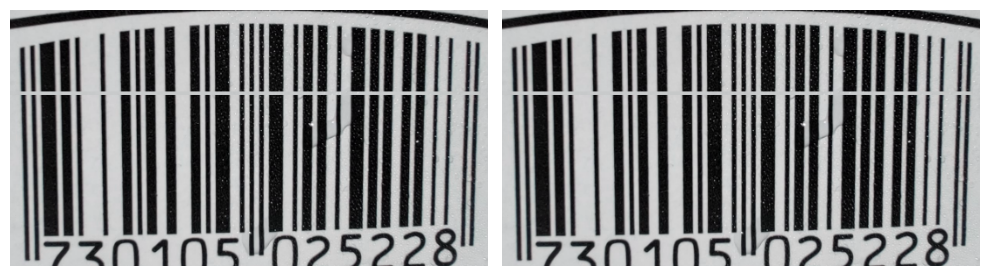

In [21]:
# single_image_white_gap_ratio.py
# Detecta línas blancas en código de barras
# Funciona mejor

import cv2
import numpy as np
from pathlib import Path

def detect_white_stripes_ratio(
    gray,
    t_white: int = 220,     # umbral de "blanco" (0–255). Bajalo si tu imagen es más gris.
    ratio_thr: float = 0.30,# porcentaje mínimo de píxeles blancos en la fila (0–1)
    min_h: int = 1,         # grosor mínimo de la raya (px)
    max_h: int = 20,        # grosor máximo de la raya (px)
    smooth_k: int = 3       # tamaño de suavizado del perfil 1D (en filas)
):
    """Devuelve bandas [(y0, y1)] donde la fila es mayormente blanca de forma contigua."""
    g = gray.astype(np.uint8)

    # Porcentaje de píxeles muy blancos por fila
    white_ratio = (g >= t_white).mean(axis=1).astype(np.float32)

    # Suaviza el perfil para evitar falsos positivos aislados
    if smooth_k > 1:
        k = np.ones(smooth_k, np.float32) / smooth_k
        white_ratio = np.convolve(white_ratio, k, mode="same")

    # Filas candidatas
    mask = white_ratio >= ratio_thr

    # Agrupa filas contiguas en bandas
    bands = []
    in_band = False
    start = 0
    for i, val in enumerate(mask):
        if val and not in_band:
            in_band = True
            start = i
        elif not val and in_band:
            in_band = False
            end = i - 1
            if min_h <= (end - start + 1) <= max_h:
                bands.append((start, end))
    if in_band:
        end = len(mask) - 1
        if min_h <= (end - start + 1) <= max_h:
            bands.append((start, end))

    return bands

def main():
    img_path = Path("/content/sample_data/conaprole4.png")  # tu archivo
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"No se pudo leer {img_path.resolve()}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecta la(s) raya(s) blanca(s) horizontales
    bands = detect_white_stripes_ratio(
        gray,
        t_white=220,     # subir a 230–240 si hay mucho gris claro; bajar a 200 si la iluminación es baja
        ratio_thr=0.30,  # si no detecta, probá 0.25; si detecta ruido, subí a 0.35–0.45
        min_h=1,
        max_h=20,
        smooth_k=3
    )

    # Anota y guarda
    annot = img.copy()
    for (y0, y1) in bands:
        cv2.rectangle(annot, (0, y0), (annot.shape[1]-1, y1), (255, 0, 0), 2)

    out_path = Path("sampleImage_annot.png")
    cv2.imwrite(str(out_path), annot)

    print(f"Bands: {bands}")
    print(f"Annotated saved to: {out_path.resolve()}")

    # Mostrar imagenes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img)
    axs[0].axis('off')

    axs[1].imshow(annot)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
